In [4]:
import pandas as pd
import math
infile = r'../excels/sortedAll2004-2021.csv'
infile2 = r'../excels/sortedAll2004-2021Remaining.csv'
# rowCount = 100000
rowCount = 1048690

data = pd.read_csv(infile, skiprows = 0, nrows=rowCount)
data = data.drop(['Unnamed: 0', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14'], axis=1)
for index, row in data.iterrows():
    if row['deltOwned'][0]=='N':
        data.loc[index, "deltOwned"] = 0
        data.loc[index, "Value"] = float(row['Price'])*int(row['Qty'])

data2 = pd.read_csv(infile2, skiprows = 0)
# data2 = data.drop(['Unnamed: 0', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14'], axis=1)
for index, row in data2.iterrows():
    if row['deltOwned'][0]=='N':
        data2.loc[index, "deltOwned"] = 0
        data2.loc[index, "Value"] = float(row['Price'])*int(row['Qty'])

data = data.append(data2, ignore_index = True)

data

/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


FileNotFoundError: [Errno 2] No such file or directory: '../excels/sortedAllRemaining2004-2021.csv'

### gameplan:
-iterate through rows
-if insider makes a purchase, add them to dictionary of traders---initialize amount to purchased. 
-dictionary has format key=name (as seen in dataframe) value=dictionary which includes: queue of trades (tuple with ticker, price, trade date, quantity of shares, total value). updates dynamically with time. if sale is made and all shares of a given previous purchase is sold, then it is popped from the queue and the next purchase up is decremented accordingly. 

-also sum the amount spent in purchases for each insider to get their return

In [11]:
# insiders = {
#     "ExampleName":{"Title(s)":[], "Affiliated Company":"Comp Name", "Profit":0, "Amount Inv":0, "Return":0, "Equity Dist":{}, "Trade Count":0, "Shares Traded":0, "Shares Held":0, "Trade Data":[], "Trades":[], "Trades by Ticker":{'TickerExample':[[]]}} #could also have itemized equity holdings by each of their company holdings, etc.
# }
insiders = {}

for index, row in data.iterrows():
    
    if float(row["Price"]) == 0:
        continue  #may be a problem when they sell high-value yet 0-price purchases...
    
    if row['Insider Name'] not in insiders and row['Trade Type']=="P - Purchase":
        insiders[row['Insider Name']] = { "Title(s)":list(row['Title'].split(', ')), 
                                         "Affiliated Company":row["Company Name"], 
                                         "Profit":0, 
                                         "Amount Inv":float(row["Value"]),
                                         "Return":0,
                                         "Equity Dist": { row["Ticker"] : float(row["Value"])}, 
                                         "Trade Count":1, 
                                         "Shares Traded":int(row["Qty"]), 
                                         "Shares Held":int(row["Qty"]), 
                                         "Trade Data":[row.tolist()], 
                                         "Trades by Ticker":{row["Ticker"] : [ [ int(row["Qty"]), float(row["Price"]), row['Trade Date'] ] ]},
#                                          "Avg Hold Time":0 #get difference between two dates...google
                                        }
    elif row['Trade Type']=="P - Purchase":
        
        insiders[row['Insider Name']]["Amount Inv"] += float(row["Value"])        
        
        if row["Ticker"] in insiders[row['Insider Name']]["Equity Dist"]:
            insiders[row['Insider Name']]["Equity Dist"][row["Ticker"]]+=float(row["Value"])
        else:
            insiders[row['Insider Name']]["Equity Dist"][row["Ticker"]] = float(row["Value"])
        
        insiders[row['Insider Name']]["Trade Count"]+=1
        insiders[row['Insider Name']]["Shares Traded"] += int(row["Qty"])
        insiders[row['Insider Name']]["Shares Held"] += int(row["Qty"])
        insiders[row['Insider Name']]["Trade Data"].append(row.tolist())
        
#         insiders[row['Insider Name']]["Trades"].append([ row["Ticker"], int(row["Qty"].replace(',', '')), float(row["Price"].replace(',', '')), row['Trade Date'] ])
        if row["Ticker"] in insiders[row['Insider Name']]["Trades by Ticker"]:
            insiders[row['Insider Name']]["Trades by Ticker"][row['Ticker']].append([ int(row["Qty"]), float(row["Price"]), row['Trade Date'] ])
        else:
            insiders[row['Insider Name']]["Trades by Ticker"][row['Ticker']] = [[ int(row["Qty"]), float(row["Price"]), row['Trade Date'] ]]
    
    elif row['Trade Type'][0]=='S' and row['Insider Name'] in insiders and (row['Ticker'] in insiders[row['Insider Name']]['Equity Dist'] ):    
        #what if sale *qty* is greater than total equity---in that case just subtract the total held qty down to 0 and move on
        qty = int(row["Qty"])*(-1)
        sellPrice = float(row["Price"])
        while qty > 0 and insiders[row['Insider Name']]["Trades by Ticker"][row['Ticker']]:
            heldQtyTop = insiders[row['Insider Name']]["Trades by Ticker"][row['Ticker']][0][0] #dynamic qty of purchased shares
            buyPrice = insiders[row['Insider Name']]["Trades by Ticker"][row['Ticker']][0][1]
            
            if qty > heldQtyTop:
                insiders[row['Insider Name']]["Profit"]+=(sellPrice*heldQtyTop - buyPrice*heldQtyTop)
                qty -= heldQtyTop
                insiders[row['Insider Name']]["Trades by Ticker"][row['Ticker']].pop(0)
                
            else:
                #simply decrement from the current holding qty and change the profit accordingly
                insiders[row['Insider Name']]["Profit"]+=(sellPrice*qty - buyPrice*qty)
                insiders[row['Insider Name']]["Trades by Ticker"][row['Ticker']][0][0] -= qty
                qty = 0
#         print(insiders[row['Insider Name']]["Amount Inv"], row['Insider Name'], insiders[row['Insider Name']], '-----\n', row, "\n\n")
        if insiders[row['Insider Name']]["Profit"] != 0:
            insiders[row['Insider Name']]["Return"]=round(insiders[row['Insider Name']]["Profit"]/insiders[row['Insider Name']]["Amount Inv"], 2)
        

In [12]:
insiders

{'Bristow Peter M': {'Title(s)': ['EVP', 'COO'],
  'Affiliated Company': 'First Citizens Bancorporation of South Carolina Inc',
  'Profit': 6300.0,
  'Amount Inv': 331016.0,
  'Return': 0.02,
  'Equity Dist': {'FCBN': 264760.0, 'FCNCA': 66256.0},
  'Trade Count': 11,
  'Shares Traded': 1911,
  'Shares Held': 1911,
  'Trade Data': [['1/1/04',
    'FCBN',
    'Bristow Peter M',
    'First Citizens Bancorporation of South Carolina Inc',
    'EVP, COO',
    'P - Purchase',
    475.0,
    46,
    25817,
    '0',
    '21850',
    nan],
   ['3/17/04',
    'FCBN',
    'Bristow Peter M',
    'First Citizens Bancorporation of South Carolina Inc',
    'EVP, COO',
    'P - Purchase',
    482.0,
    60,
    25877,
    '0',
    '28920',
    nan],
   ['4/7/04',
    'FCBN',
    'Bristow Peter M',
    'First Citizens Bancorporation of South Carolina Inc',
    'EVP, COO',
    'P - Purchase',
    530.0,
    105,
    25982,
    '0',
    '55650',
    nan],
   ['9/15/04',
    'FCBN',
    'Bristow Peter M',


In [13]:
returnsList = []
for insider in insiders:
#     if insiders[insider]['Profit']>0:
    returnsList.append([ insiders[insider]['Return'], insiders[insider]['Trade Count'], insider, insiders[insider]['Amount Inv'], insiders[insider]['Title(s)'] ])

returnsList = sorted(returnsList, 
       key=lambda x: x[0], reverse=True)
returnsList

[[1602786.46, 1, 'Neuson Kramer Baumaschinen AG', 14350.0, ['10%']],
 [5923.05, 1, 'Trina Chris', 50000.0, ['CEO', '10%']],
 [2549.54, 2, 'Aspect Capital Ltd', 10002400.0, ['10%']],
 [326.17, 1, 'Reed Darryl W', 47500.0, ['CEO', '10%']],
 [170.05, 5, 'Rothermel Robert B', 128079.0, ['Dir']],
 [155.1, 1, 'Us Special Opportunities Trust Plc', 12635.0, ['10%']],
 [137.3, 1, 'Conzen Jay', 75.0, ['Dir']],
 [99.0, 1, 'Wai Hok Fung', 499950.0, ['CEO', 'Pres', '10%']],
 [88.29, 2, 'Eardley Kip', 68425.0, ['Pres', 'Secretary', '10%']],
 [85.76, 1, 'Girschweiler Thomas', 240219.0, ['Dir', '10%']],
 [79.38, 1, 'Liang Howard', 120250.0, ['CFO', 'Chief Strategy Officer']],
 [78.52, 1, 'Abacus Investments Ltd.', 100000.0, ['10%']],
 [70.78, 13, 'Erck Stanley C', 605226.0, ['Dir']],
 [65.0, 1, 'Jones Brian', 5000.0, ['EVP', 'Co-COO']],
 [63.43, 9, 'Trizzino John', 372397.0, ['Snr. VP', 'Int', 'Govt Alliances']],
 [59.51, 1, 'Rey Eric J.', 3750.0, ['Dir']],
 [55.37, 6, 'Simoncini Matthew', 1648108.0, 

In [14]:
data.loc[data['Insider Name'] == 'Rabussay Dietmar P']

Trade Date Ticker        Insider Name                 Company Name  \
61902    9/16/04    GEB  Rabussay Dietmar P  Genetronics Biomedical Corp   
72463   11/11/04    GEB  Rabussay Dietmar P  Genetronics Biomedical Corp   

                          Title    Trade Type    Price  Qty  Owned deltOwned  \
61902  VP Research, Development  P - Purchase  5882.35    1      1         0   
72463  VP Research, Development      S - Sale     3.41 -250  17386        -1   

         Value  Unnamed: 0  
61902  5882.35         NaN  
72463     -853         NaN

##### TODO: sum up the amount spent on purchases by each insider so that we can get the return for each individual
##### sum up the amount spent by each position and the return of each position. see which has highest
##### for (position, individual) get total profit, average and median return---profit/spent


##### eventually, want to get the current value (or maybe average of the past year) of presently-held stocks so that returns can be measured for insiders who bought and held until the present

##### have to also have a way of measuring returns per year of investing...eg. do they get a high return in a short period of time?
##### ^to discover this, consider taking the range of time between buying and selling a given stock. take an average holding period for each stock, for example. IOW, are they making quick money on certain stocks?
##### how do we combine our view of time a stock is held with the return of the holder? maybe a 2-d scatterplot. (add in total volume $ traded for a third dimension)


In [15]:
#TODO: sum up the amount spent on purchases by each insider so that we can get the return for each individual
#sum up the amount spent by each position and the return of each position. see which has highest
#for (position, individual) get total profit, average and median return---profit/spent


#eventually, want to get the current value (or maybe average of the past year) of presently-held stocks so that returns can be measured for insiders who bought and held until the present

#have to also have a way of measuring returns per year of investing...eg. do they get a high return in a short period of time?
#^to discover this, consider taking the range of time between buying and selling a given stock. take an average holding period for each stock, for example. IOW, are they making quick money on certain stocks?
#how do we combine our view of time a stock is held with the return of the holder? maybe a 2-d scatterplot. (add in total volume $ traded for a third dimension)

#DO WEIGHTED RETURNS!!! BY THE AMOUNT SPENT???


In [16]:
returnsList

[[1602786.46, 1, 'Neuson Kramer Baumaschinen AG', 14350.0, ['10%']],
 [5923.05, 1, 'Trina Chris', 50000.0, ['CEO', '10%']],
 [2549.54, 2, 'Aspect Capital Ltd', 10002400.0, ['10%']],
 [326.17, 1, 'Reed Darryl W', 47500.0, ['CEO', '10%']],
 [170.05, 5, 'Rothermel Robert B', 128079.0, ['Dir']],
 [155.1, 1, 'Us Special Opportunities Trust Plc', 12635.0, ['10%']],
 [137.3, 1, 'Conzen Jay', 75.0, ['Dir']],
 [99.0, 1, 'Wai Hok Fung', 499950.0, ['CEO', 'Pres', '10%']],
 [88.29, 2, 'Eardley Kip', 68425.0, ['Pres', 'Secretary', '10%']],
 [85.76, 1, 'Girschweiler Thomas', 240219.0, ['Dir', '10%']],
 [79.38, 1, 'Liang Howard', 120250.0, ['CFO', 'Chief Strategy Officer']],
 [78.52, 1, 'Abacus Investments Ltd.', 100000.0, ['10%']],
 [70.78, 13, 'Erck Stanley C', 605226.0, ['Dir']],
 [65.0, 1, 'Jones Brian', 5000.0, ['EVP', 'Co-COO']],
 [63.43, 9, 'Trizzino John', 372397.0, ['Snr. VP', 'Int', 'Govt Alliances']],
 [59.51, 1, 'Rey Eric J.', 3750.0, ['Dir']],
 [55.37, 6, 'Simoncini Matthew', 1648108.0, 

In [17]:
import collections
##commented here are with multiple attributes for each position, whereas subsequent uncommented is dictionary of only returns
# positionStats = {}
# for row in returnsList:
#     for position in row[4]:
#         if row[0] !=0:
#             if position not in positionStats:
#                 positionStats[position]={}
#                 positionStats[position]['Returns'] = []

#             positionStats[position]['Returns'].append(row[0])
# positionStats
positionStats = {}
for row in returnsList:
    for position in row[4]:
        if row[0] !=0:
            if position not in positionStats:
                positionStats[position]=[]

            positionStats[position].append(row[0])

# d = {"one": [(1,3),(1,4)], "two": [(1,2),(1,2),(1,3)], "three": [(1,1)]}
# >>> for k in sorted(d, key=lambda k: len(d[k]), reverse=True):
#         print k,


# two one three

#to order the previously-made dictionary or returns by position, we have this next line
positionStats = collections.OrderedDict(sorted(positionStats.items(), key= lambda x: len(x[1]), reverse=True))

positionStats

OrderedDict([('Dir',
              [170.05,
               137.3,
               85.76,
               70.78,
               59.51,
               47.25,
               36.56,
               31.89,
               30.54,
               28.98,
               25.81,
               24.39,
               24.38,
               23.22,
               22.44,
               20.11,
               18.99,
               18.43,
               18.19,
               18.06,
               17.45,
               17.32,
               16.36,
               15.93,
               15.36,
               14.63,
               14.18,
               14.15,
               13.97,
               13.92,
               13.65,
               13.4,
               13.36,
               12.97,
               12.89,
               12.78,
               12.64,
               12.54,
               12.5,
               12.43,
               12.35,
               12.26,
               12.06,
               11.87,
            

/var/folders/cn/bl_17ghs1c36tj34j2pxt3gh0000gn/T/ipykernel_48849/2049124718.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(titlesCounts)
/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


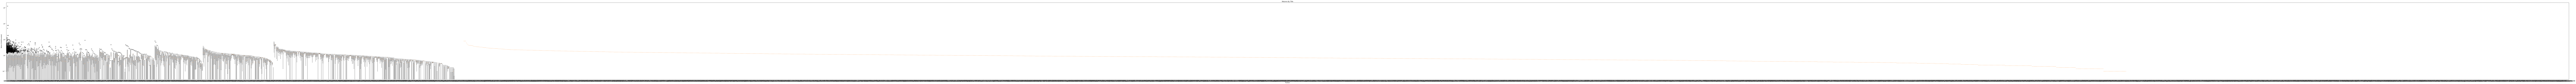

In [18]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

boxPosRetData = list(positionStats.values())

fig = plt.figure(figsize =(300, 9))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

titlesCounts = []
for pos in positionStats:
    titlesCounts.append(pos+' ('+str(len(positionStats[pos]))+')')

# x-axis labels
ax.set_xticklabels(titlesCounts)

plt.title('Returns By Title')
plt.xlabel('Position')
plt.ylabel('Return (Profit/Invested)')

#log scale y-axis to make comparison easier
ax.set_yscale('log')

# Creating plot
bp = ax.boxplot(boxPosRetData)

# show plot
plt.show()


In [19]:
positionStats

OrderedDict([('Dir',
              [170.05,
               137.3,
               85.76,
               70.78,
               59.51,
               47.25,
               36.56,
               31.89,
               30.54,
               28.98,
               25.81,
               24.39,
               24.38,
               23.22,
               22.44,
               20.11,
               18.99,
               18.43,
               18.19,
               18.06,
               17.45,
               17.32,
               16.36,
               15.93,
               15.36,
               14.63,
               14.18,
               14.15,
               13.97,
               13.92,
               13.65,
               13.4,
               13.36,
               12.97,
               12.89,
               12.78,
               12.64,
               12.54,
               12.5,
               12.43,
               12.35,
               12.26,
               12.06,
               11.87,
            

In [20]:
posDF = pd.DataFrame(columns=['Position', 'Count', 'Min', 'Q1', 'Q2', 'Q3', 'Max', 'Average', 'StDev', 'Q1/Q2 Avg'])
# In [5]: df = pd.DataFrame(columns=['A','B','C','D','E','F','G'])

for key in positionStats:
    stats = pd.Series(positionStats[key]).describe()
#     time_diff.describe()
    item = []
#     posDF['Position'] = key
#     posDF['Count'] = stats['count']
#     posDF['Min'] = stats['min']
#     posDF['Q1'] = stats['25%']
#     posDF['Q2'] = stats['50%']
#     posDF['Q3'] = stats['75%']
#     posDF['Max'] = stats['max']
#     posDF['Average'] = stats['mean']
#     posDF['StDev'] = stats['std']
#     posDF['Q1/Q2 Avg'] = (stats['25%'] + stats['50%'])/2
    item.append(key)
    item.append(int(stats['count']))
    item.append(round(stats['min'], 2))
    item.append(round(stats['25%'], 2))
    item.append(round(stats['50%'], 2))
    item.append(round(stats['75%'], 2))
    item.append(round(stats['max'], 2))
    item.append(round(stats['mean'], 2))
    item.append(round(stats['std'], 2))
    item.append(round((stats['25%'] + stats['50%'])/2, 2))
    
#     posDF.append(item, ignore_index=True)
    posDF.loc[len(posDF)] = item
#     print(item)
posDF

Position Count     Min    Q1    Q2    Q3         Max  \
0                             Dir  7759 -615.24  0.01  0.26  0.86      170.05   
1                             10%  2500 -117.64 -0.09  0.10  0.64  1602786.46   
2                             CEO  2362   -1.44  0.01  0.31  1.03     5923.05   
3                            Pres  2087   -0.99  0.03  0.33  1.01       99.00   
4                             CFO  1612   -1.00  0.06  0.44  1.20       79.38   
...                           ...   ...     ...   ...   ...   ...         ...   
3139  VP Converted Products Group     1   -0.98 -0.98 -0.98 -0.98       -0.98   
3140           VP Recovered Fiber     1   -0.99 -0.99 -0.99 -0.99       -0.99   
3141                VP-Chartering     1   -0.99 -0.99 -0.99 -0.99       -0.99   
3142                    EVP-Devel     1   -0.99 -0.99 -0.99 -0.99       -0.99   
3143           Pres-US Operations     1   -1.00 -1.00 -1.00 -1.00       -1.00   

      Average     StDev  Q1/Q2 Avg  
0        0.76      7.80       0.14  
1      645.36  32055.90       0.01  
2        3.71    122.09       0.16  
3        1.02      3.77       0.18  
4        1.20      3.53       0.25  
...       ...       ...        ...  
3139    -0.98       NaN      -0.98  
3140    -0.99       NaN      -0.99  
3141    -0.99       NaN      -0.99  
3142    -0.99       NaN      -0.99  
3143    -1.00       NaN      -1.00  

[3144 rows x 10 columns]

In [21]:
posDF.to_csv('positionReturnsData04-21.csv', index=False)